## Data Retrieved

USF All data retrieved 04/30/24:
https://redistrictingdatahub.org/dataset/virginia-block-pl-94171-2020-by-table/
https://redistrictingdatahub.org/dataset/vest-2020-virginia-precinct-boundaries-and-election-results-shapefile/
https://redistrictingdatahub.org/dataset/2021-virginia-congressional-districts-approved-plan/

https://redistrictingdatahub.org/dataset/vest-2018-virginia-precinct-and-election-results/
https://redistrictingdatahub.org/dataset/vest-2016-virginia-precinct-and-election-results/
https://redistrictingdatahub.org/dataset/vest-2021-virginia-precinct-boundaries-and-election-results-shapefile/
https://redistrictingdatahub.org/dataset/vest-2017-virginia-precinct-boundaries-and-election-results-shapefile/

https://redistrictingdatahub.org/dataset/2021-senate-of-virginia-districts-approved-plan/
https://redistrictingdatahub.org/dataset/2021-virginia-house-of-delegates-districts-approved-plan/

In [4]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# state = Virginia
state_ab = "va"

## Data
1. Download all the data in directory "va_data"
2. Extract them all

In [8]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest21_data = "./{}{}_vest_21/{}_vest_21.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest17_data = "./{}{}_vest_17/{}_vest_17.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2021/SCV FINAL CD.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2021/SCV FINAL SD.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/SCV FINAL HOD.shp".format(data_folder, state_ab)

In [9]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    
    # check maup doctor again to see if smart repair works
    if maup.doctor(df) == True:
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        df = df.to_crs('EPSG:4269')
        raise Exception('maup.doctor failed')
    
    return df

In [10]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs('EPSG:4269')
    dist_df = dist_df.to_crs('EPSG:4269')
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [11]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [12]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [13]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [14]:
def add_vest(vest, df, year, population, start_col):
    df = df.to_crs('EPSG:4269')
    vest = vest.to_crs('EPSG:4269')
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = "EPSG:4269")
    # check if population agrees
    check_population(population, df)
    
    return df

### Read the census data

In [16]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [17]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [18]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [19]:
maup.doctor(population_df)

100%|█████████████████████████████████| 163491/163491 [01:08<00:00, 2373.68it/s]


True

In [20]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [21]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [22]:
population_df.rename(columns=rename_dict, inplace = True)

In [23]:
cong_df = gpd.read_file(cd_data)
maup.doctor(cong_df)

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 61.61it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

In [25]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [27]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████████████████████████████████| 2477/2477 [00:03<00:00, 716.41it/s]


There are 58 overlaps.
There are 587 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2623/2623 [00:00<00:00, 3747.72it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2477/2477 [00:03<00:00, 756.26it/s]


In [28]:
vest20.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREOWRI', 'G20USSDWAR', 'G20USSRGAD', 'G20USSOWRI',
       'geometry'],
      dtype='object')

In [29]:
start_col = 4
vest_base_data = vest20
year = '20'

In [30]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [31]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 2477/2477 [00:17<00:00, 138.26it/s]


In [32]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [33]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

## Check if population agrees

In [35]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,8631393,8631393.0,True
HISP,HISP,908749,908749.0,True
NH_WHITE,NH_WHITE,5058363,5058363.0,True
NH_BLACK,NH_BLACK,1578090,1578090.0,True
NH_AMIN,NH_AMIN,19080,19080.0,True
NH_ASIAN,NH_ASIAN,610612,610612.0,True
NH_NHPI,NH_NHPI,6195,6195.0,True
NH_OTHER,NH_OTHER,45394,45394.0,True
NH_2MORE,NH_2MORE,404910,404910.0,True
H_WHITE,H_WHITE,150493,150493.0,True


## Add more vest data

In [37]:
vest21 = gpd.read_file(vest21_data)
vest18 = gpd.read_file(vest18_data)
vest17 = gpd.read_file(vest17_data)
vest16 = gpd.read_file(vest16_data)

In [38]:
vest21.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G21GOVRYOU', 'G21GOVDMCA',
       'G21GOVLBLA', 'G21GOVOWRI', 'G21LTGRSEA', 'G21LTGDAYA', 'G21LTGOWRI',
       'G21ATGRMIY', 'G21ATGDHER', 'G21ATGOWRI', 'geometry'],
      dtype='object')

In [39]:
vest18.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G18USSDKAI', 'G18USSRSTE',
       'G18USSLWAT', 'G18USSOWRI', 'geometry'],
      dtype='object')

In [40]:
vest17.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G17GOVDNOR', 'G17GOVRGIL',
       'G17GOVLHYR', 'G17GOVOWRI', 'G17LTGDFAI', 'G17LTGRVOG', 'G17LTGOWRI',
       'G17ATGDHER', 'G17ATGRADA', 'G17ATGOWRI', 'geometry'],
      dtype='object')

In [41]:
vest16.columns

Index(['COUNTYFP', 'LOCALITY', 'VTDST', 'PRECINCT', 'G16PREDCLI', 'G16PRERTRU',
       'G16PRELJOH', 'G16PREIMCM', 'G16PREGSTE', 'G16PREOWRI', 'geometry'],
      dtype='object')

In [42]:
# check the result here
election_df = add_vest(vest21, election_df, '21', population_df, start_col)
election_df = add_vest(vest18, election_df, '18', population_df, start_col)
election_df = add_vest(vest17, election_df, '17', population_df, start_col)
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████████████████████████████████| 2479/2479 [00:03<00:00, 743.45it/s]


There are 58 overlaps.
There are 588 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2624/2624 [00:00<00:00, 3778.24it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2477/2477 [00:18<00:00, 136.04it/s]


population agrees


100%|██████████████████████████████████████| 2463/2463 [00:03<00:00, 688.19it/s]


There are 35 overlaps.
There are 88 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2574/2574 [00:00<00:00, 3795.23it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2477/2477 [00:18<00:00, 135.70it/s]


population agrees


100%|██████████████████████████████████████| 2463/2463 [00:03<00:00, 748.43it/s]


There are 35 overlaps.
There are 90 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2577/2577 [00:00<00:00, 3786.28it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2477/2477 [00:18<00:00, 137.23it/s]


population agrees


100%|██████████████████████████████████████| 2456/2456 [00:03<00:00, 666.78it/s]


There are 36 overlaps.
There are 89 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 2571/2571 [06:27<00:00,  6.64it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2477/2477 [00:18<00:00, 133.29it/s]


population agrees


##  Add the district data

In [44]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [45]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICTN")

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  9.76it/s]


In [46]:
election_df = add_district(send, "SEND", election_df, "DISTRICTN")

100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 19.48it/s]


In [47]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICTN")

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.60it/s]


In [48]:
maup.doctor(election_df)

100%|██████████████████████████████████████| 2477/2477 [00:03<00:00, 743.83it/s]


True

In [49]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG17D', 'ATG17O', 'ATG17R',
       'ATG21D', 'ATG21O', 'ATG21R', 'BVAP', 'COUNTYFP', 'GOV17D', 'GOV17O',
       'GOV17R', 'GOV21D', 'GOV21O', 'GOV21R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'LOCALITY', 'LTG17D', 'LTG17O', 'LTG17R', 'LTG21D', 'LTG21O', 'LTG21R',
       'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI',
       'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'TOTPOP', 'USS18D', 'USS18O',
       'USS18R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST', 'WVAP',
       'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [51]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'PRECINCT':'PRECINCT'+year,
        'LOCALITY':'LOCALITY'+year} 
election_df.rename(columns=base_columns, inplace = True)

In [52]:
# reorder the columns
fixed_columns = [
    'COUNTYFP'+year,
    'VTDST'+year,
    'PRECINCT'+year,
    'LOCALITY'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [53]:
election_df.columns

Index(['COUNTYFP20', 'VTDST20', 'PRECINCT20', 'LOCALITY20', 'CD', 'SEND',
       'HDIST', 'TOTPOP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'HISP', 'H_AMIN', 'H_ASIAN',
       'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'ATG17D', 'ATG17O', 'ATG17R', 'ATG21D', 'ATG21O', 'ATG21R',
       'GOV17D', 'GOV17O', 'GOV17R', 'GOV21D', 'GOV21O', 'GOV21R', 'LTG17D',
       'LTG17O', 'LTG17R', 'LTG21D', 'LTG21O', 'LTG21R', 'PRE16D', 'PRE16O',
       'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'geometry'],
      dtype='object')

In [54]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

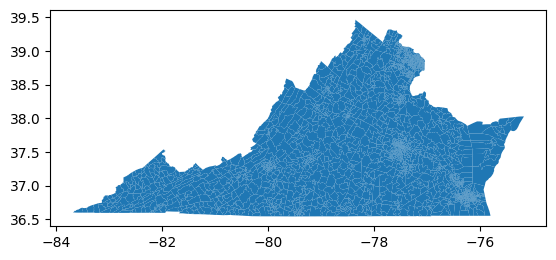

In [55]:
shape=gpd.read_file('va/va.shp')
shape.plot()